In [1]:
from symred.build_model import build_molecule_for_projection
from symred.utils import exact_gs_energy, quasi_model
import json
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from itertools import combinations, product
import openfermion as of
import openfermionpyscf as ofpyscf
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HO

# Build the molecule and CS-VQE model

In [332]:
# Set molecule parameters
speciesname = 'Be_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)
model = build_molecule_for_projection(calculated_molecule, basis_weighting='ham_coeff')

------------------------------------------------
Information concerning the full system:
------------------------------------------------
Number of qubits in full problem: 10
The Hartree-Fock state is |1111000000>
HF   energy = -14.35188048
MP2  energy = -14.37623885
CISD energy = -14.40364578
CCSD energy = -14.40365075
FCI energy  = -14.40365511
------------------------------------------------
Tapering information:
------------------------------------------------
We are able to taper 5 qubits from the Hamiltonian
The symmetry sector is:
1 ZIZIIZIZIZ +
1 IZIZIZIZIZ +
1 IIIIZZIIII +
1 IIIIIIZZII +
1 IIIIIIIIZZ
The tapered Hartree-Fock state is |11000>
------------------------------------------------
CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -14.352558957524035
Symmetry generators:    
1 IIIIZ +
1 IIIZI +
1 IIZII +
-1 ZIZZZ
Clique representatives: 
-0.9997423322 IZZZZ +
-0.0226995442 IXIII
-----------------------------------------------

In [334]:
num_sim_q = 3
stab_indices = model.greedy_search(num_sim_q)
projected = model.contextual_subspace_projection(stab_indices)
nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
error = abs(nrg-model.fci_energy)
print(f'{projected.n_qubits}-qubit CS-VQE error: {error: .6f} | stabilizer indices: {stab_indices}')

1-qubit CS-VQE error:  0.031615
2-qubit CS-VQE error:  0.015027
3-qubit CS-VQE error:  0.001190
------ done ------
3-qubit CS-VQE error:  0.001190 | stabilizer indices: [0, 4]


In [335]:
ham_cs = model.contextual_subspace_projection(stab_indices)
ref_cs = model.hf_tapered[model.free_qubit_indices]
ucc_cs = model.contextual_subspace_projection(stab_indices, aux_operator=model.ucc_tap)

def qiskit_ordering(indices):
        return ham_cs.n_qubits - 1 - indices
    
qc = QuantumCircuit(ham_cs.n_qubits)
for i in qiskit_ordering(np.where(ref_cs==1)[0]):
    qc.x(i)

circuit_instructions = {}
for step, (X,Z) in enumerate(zip(ucc_cs.X_block, ucc_cs.Z_block)):
    # locations for H and S gates to transform into Pauli Z basis
    H_indices = qiskit_ordering(np.where(X)[0])[::-1]
    S_indices = qiskit_ordering(np.where(X & Z)[0])[::-1]
    # CNOT cascade indices
    CNOT_indices = qiskit_ordering(np.where(X | Z)[0])[::-1]
    
    circuit_instructions[step] = {'H_indices':H_indices, 
                                  'S_indices':S_indices, 
                                  'CNOT_indices':CNOT_indices,
                                  'RZ_index':CNOT_indices[-1]}
    
def CNOT_cascade(cascade_indices, reverse=False):
    index_pairs = list(zip(cascade_indices[:-1], cascade_indices[1:]))
    if reverse:
        index_pairs = index_pairs[::-1]
    for source, target in index_pairs:
        qc.cx(source, target)

def circuit_from_step(angle, H_indices, S_indices, CNOT_indices, RZ_index):
    # to Pauli X basis
    for i in S_indices:
        qc.s(i)
    # to Pauli Z basis
    for i in H_indices:
        qc.h(i)
    # compute parity
    CNOT_cascade(CNOT_indices)
    qc.rz(2*angle, RZ_index)
    CNOT_cascade(CNOT_indices, reverse=True)
    for i in H_indices:
        qc.h(i)
    for i in S_indices:
        qc.sdg(i)
    
def circ_from_instructions(instructions, angles, trotter_number=2):
    angles= np.array(angles)/trotter_number
    assert(len(angles)==len(instructions))
    for trot_step in range(trotter_number):
        for step, gate_indices in instructions.items():
            circuit_from_step(angles[step], *gate_indices.values())
    return qc

qc = circ_from_instructions(circuit_instructions, ParameterVector('P', ucc_cs.n_terms))
print(qc.draw())

     ┌───┐┌───┐┌──────────┐┌───┐┌─────┐┌───┐┌───┐                           »
q_0: ┤ S ├┤ H ├┤ Rz(P[0]) ├┤ H ├┤ Sdg ├┤ S ├┤ H ├──■────────────────────────»
     └───┘└───┘└──────────┘└───┘└─────┘└───┘└───┘┌─┴─┐                      »
q_1: ────────────────────────────────────────────┤ X ├──■────────────────■──»
                                                 └───┘┌─┴─┐┌──────────┐┌─┴─┐»
q_2: ─────────────────────────────────────────────────┤ X ├┤ Rz(P[1]) ├┤ X ├»
                                                      └───┘└──────────┘└───┘»
«          ┌───┐┌─────┐                                                        »
«q_0: ──■──┤ H ├┤ Sdg ├────────────────────────────────────■───────────────────»
«     ┌─┴─┐├───┤└┬───┬┘┌──────────┐┌───┐┌─────┐┌───┐┌───┐┌─┴─┐                 »
«q_1: ┤ X ├┤ S ├─┤ H ├─┤ Rz(P[2]) ├┤ H ├┤ Sdg ├┤ S ├┤ H ├┤ X ├──■──────────────»
«     └───┘└───┘ └───┘ └──────────┘└───┘└─────┘└───┘└───┘└───┘┌─┴─┐┌──────────┐»
«q_2: ───────────────────────────────────────────

# Noiseless VQE

In [336]:
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP, SNOBFIT, COBYLA
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE

seed = 42
backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

interim_results = {'counts':[], 'prmset':[], 'values':[], 'errors':[]}
def store_interim_results(eval_count, parameters, mean, std):
    """ Outputs intermediate data during VQE routine
    """
    interim_results['counts'].append(eval_count)
    interim_results['prmset'].append(parameters)
    interim_results['values'].append(mean)
    interim_results['errors'].append(std)
    
def dict_to_WeightedPauliOperator(op):
    assert(type(op) == dict)
    return sum([PauliOp(Pauli(p), op[p]) for p in op.keys()])

# simulate the input Hamiltonian
vqe = VQE(ansatz=qc, 
          initial_point=np.zeros(ucc_cs.n_terms), 
          optimizer=COBYLA(maxiter=5000), 
          callback=store_interim_results, 
          quantum_instance=qi)
vqe_input_ham = dict_to_WeightedPauliOperator(ham_cs.to_dictionary)
vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham)

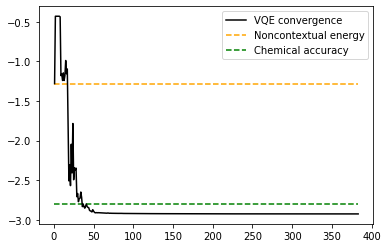

In [337]:
X = np.array(interim_results['counts'])
Y = np.array(interim_results['values'])
plt.plot(X, np.log10(Y-model.fci_energy), color='black', label='VQE convergence')
plt.hlines(np.log10(abs(model.noncontextual_energy-model.fci_energy)), 0, X[-1], color='orange', ls='--', label='Noncontextual energy')
plt.hlines(np.log10(0.0016), 0, X[-1], color='green', ls='--', label='Chemical accuracy')
plt.legend()

# VQE with statistical noise

In [349]:
import pyzx as zx
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.opflow import CircuitStateFn
from qiskit.visualization import plot_histogram
from copy import deepcopy
from collections import Counter
from operator import add
from functools import reduce

backend = BasicAer.get_backend('qasm_simulator')

def QWC_grouping(ham):
    # group Hamiltonian terms that may be estimated simulataneously
    term_grouping = {}
    for term in ham:
        X = [i for i,Pi in enumerate(term) if Pi=='X']
        Y = [i for i,Pi in enumerate(term) if Pi=='Y']
        key = f'{X}_{Y}'
        if key not in term_grouping:
            term_grouping[key] = {'paulis':[term]}
        else:
            term_grouping[key]['paulis'].append(term)
            
    return term_grouping

def bound_circuit(qc, params, ZX_reduce=False):
    variables   = qc.parameters
    assert(len(params)==len(variables))
    bind_params = {p:v for p,v in zip(variables, params)}
    bound_qc    = qc.bind_parameters(bind_params)
    if ZX_reduce:
        # to perform ZX-calculus optimization
        qc_qasm = bound_qc.qasm()
        qc_pyzx = zx.Circuit.from_qasm(qc_qasm)
        g = qc_pyzx.to_graph()
        zx.full_reduce(g)#, quiet=False) # simplifies the Graph in-place
        g.normalize()
        c_opt = zx.extract_circuit(g.copy())
        simplified_qc = QuantumCircuit.from_qasm_str(c_opt.to_qasm())
        return simplified_qc
    else:
        return bound_qc

svec = False
# function to evaluation expectation value of Pauli Z-type operator wrt bitstring
eigvals={'I':{'0':1, '1':1}, 'Z':{'0':1, '1':-1}}
def Z_expectation(pauli, bitstring):
    out=1
    for Pi,bi in zip(pauli, bitstring):
        out*=eigvals[Pi][bi]
    return out

# function that generates measurement outcomes per Hamiltonian term group (applies H, Sdg gates as necessary)
# then manually computes the corresponding expectation value
def expectation(qc, term_grouping, n_shots):
    # determine counts
    for XY in term_grouping:
        qc_copy = qc.copy()
        X_Y = XY.split('_')
        X = [int(i) for i in X_Y[0][1:-1].split(',') if i!='']
        Y = [int(i) for i in X_Y[1][1:-1].split(',') if i!='']
        for i in X:
            q_pos = num_sim_q-1-i
            qc_copy.h(q_pos)
        for i in Y:
            q_pos = num_sim_q-1-i
            qc_copy.sdg(q_pos)
            qc_copy.h(q_pos)
        
        if svec:
            statevector = Statevector(qc_copy)
            counts = {}
            for sample in range(n_shots):
                outcome = statevector.measure()[0]
                if outcome in counts:
                    counts[outcome]+=1
                else:
                    counts[outcome] =1
        else:
            qc_copy.measure_all()
            # if n_shots exceeds qiskit's limit:
            if n_shots > 2**15:
                jobs = [(2**15) for i in range(n_shots//(2**15))]
                extra = n_shots%(2**15)
                if extra != 0:
                    jobs.append(extra)
            else:
                jobs = [n_shots]
            input=[]
            for shots in jobs:
                job = execute(qc_copy, backend, shots=shots)
                counts = job.result().get_counts()
                input.append(counts)
            counts = dict(reduce(add, (Counter(dict(x)) for x in input)))
        
        term_grouping[XY]['counts'] = counts
    
    # evaluate expectation value from relative frequency of measurement outcomes per group
    expectation=0
    for XY, countdata in term_grouping.items():
        paulis = countdata['paulis']
        counts = countdata['counts']
        for P in paulis:
            P_copy = list(deepcopy(P))
            for i,Pi in enumerate(P_copy):
                if Pi in ['X', 'Y']:
                    P_copy[i]='Z'
            P_copy = ''.join(P_copy)
            relative_weight=sum([Z_expectation(P_copy, state)*freq/n_shots for state, freq in counts.items()])
            expectation += ham_cs.to_dictionary[P]*relative_weight
            
    return expectation

In [436]:
from scipy.optimize import minimize

term_grouping = QWC_grouping(ham_cs.to_dictionary)
n_realize = 1
n_shots = 2**12

def objective(x):
    bound_qc = bound_circuit(qc, x)
    samples = np.array([expectation(bound_qc, term_grouping, n_shots) for itr in range(n_realize)])
    return np.mean(samples)

def derivative(x):
    derivative_vec = []
    for i in range(ucc_cs.n_terms):
        diff_vec = np.zeros(ucc_cs.n_terms)
        diff_vec[i] = np.pi/4
        derivative_vec.append(objective(x+diff_vec) - objective(x-diff_vec))
    return np.array(derivative_vec)

def cb(xk):
    print(xk)

min_val = minimize(objective, 
               x0=np.zeros(ucc_cs.n_terms), 
               jac=derivative,
               method='CG',
               options={'maxiter':10})#,#,'disp':False}, 
               #callback=cb)

In [437]:
min_val

     fun: (-14.404268311317287+0j)
     jac: array([-0.00250482+0.j,  0.00016226+0.j, -0.00236297+0.j, -0.00007981+0.j,
        0.00523444+0.j, -0.0095773 +0.j])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 20
     nit: 2
    njev: 15
  status: 2
 success: False
       x: array([-0.0951179 +0.j, -0.09138653+0.j, -0.09704984+0.j, -0.09504806+0.j,
       -0.09651294+0.j, -0.10121981+0.j])

In [439]:
abs(min_val['fun']-model.fci_energy)

0.000613203249605121

In [440]:
error

0.0011897237388165394